In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, pi

from pyfishsense import WorldPointHandler
from pyfishsense.library.constants import PIXEL_PITCH_MM

In [2]:
lens_calibration_path = Path("../demo/data/lens-calibration.pkg")
laser_calibration_path = Path("../demo/data/laser-calibration.pkg")

In [3]:
world_point_handler = WorldPointHandler(lens_calibration_path, laser_calibration_path)

In [4]:
def get_laser_projection(laser_orientation, laser_position, dist):
    focal_length_mm = world_point_handler.calibration_matrix[0][0] * PIXEL_PITCH_MM

    plane_normal = np.array([0, 0, 1])
    plane_origin = np.array([0, 0, -dist])

    laser_scalar = np.dot((plane_origin - laser_position), plane_normal) / np.dot(
        laser_orientation, plane_normal
    )
    laser_dot = laser_position + laser_orientation * laser_scalar
    laser_dot

    laser_projection = (
        -focal_length_mm
        / 1e3
        / laser_dot[2]
        * laser_dot[0:2]
        / (PIXEL_PITCH_MM / 1e3)
    ) + world_point_handler.principal_point  # in pixels

    return laser_projection

In [20]:
results = {}

for i in range(10):
    dist = float(i) / 2 + 0.5
    i_result = []

    for j in range(199):
        angle = 90 - float(j) / 100

        laser_orientation = np.array([cos(angle * pi / 180), 0, sin(angle * pi / 180)])
        laser_position = np.array([-0.3, -0.1, 0])

        world_point_handler.laser_orientation = laser_orientation
        world_point_handler.laser_position = laser_position

        i_result.append(world_point_handler.calculate_laser_parallax(get_laser_projection(laser_orientation, laser_position, dist))[2])

    results[dist] = np.array(i_result)

In [21]:
x = (np.arange(199, dtype=float)) / 100
x

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

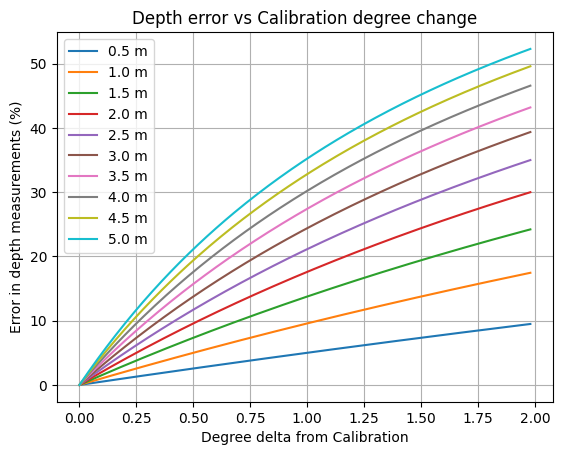

In [26]:
for i in range(10):
    dist = float(i) / 2 + 0.5

    # if dist != 1:
    #     continue

    plt.plot(x, (dist - results[dist]) / dist * 100, label=f"{dist} m")
    # plt.plot(x, results[dist], label=f"{dist} m")

plt.legend()
plt.xlabel("Degree delta from Calibration")
plt.ylabel("Error in depth measurements (%)")
plt.title("Depth error vs Calibration degree change")
plt.grid()